In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.9,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_09_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 12:42 - loss: 0.4506 - STD: 8.3543e-05 - MAE: 0.6640

 10/632 [..............................] - ETA: 3s - loss: 0.0905 - STD: 2.9331e-04 - MAE: 0.2184   

 18/632 [..............................] - ETA: 3s - loss: 0.0648 - STD: 1.6503e-04 - MAE: 0.1887

 27/632 [>.............................] - ETA: 3s - loss: 0.0533 - STD: 1.1277e-04 - MAE: 0.1733

 36/632 [>.............................] - ETA: 3s - loss: 0.0445 - STD: 8.6996e-05 - MAE: 0.1550

 45/632 [=>............................] - ETA: 3s - loss: 0.0378 - STD: 7.1232e-05 - MAE: 0.1409

 54/632 [=>............................] - ETA: 3s - loss: 0.0332 - STD: 6.0319e-05 - MAE: 0.1312

 63/632 [=>............................] - ETA: 3s - loss: 0.0300 - STD: 5.2342e-05 - MAE: 0.1234

 72/632 [==>...........................] - ETA: 3s - loss: 0.0275 - STD: 4.6387e-05 - MAE: 0.1177

 81/632 [==>...........................] - ETA: 3s - loss: 0.0255 - STD: 4.1749e-05 - MAE: 0.1134

 90/632 [===>..........................] - ETA: 3s - loss: 0.0240 - STD: 3.8021e-05 - MAE: 0.1098

 99/632 [===>..........................] - ETA: 3s - loss: 0.0227 - STD: 3.4966e-05 - MAE: 0.1068

108/632 [====>.........................] - ETA: 3s - loss: 0.0216 - STD: 3.2415e-05 - MAE: 0.1044

117/632 [====>.........................] - ETA: 3s - loss: 0.0207 - STD: 3.0253e-05 - MAE: 0.1024

125/632 [====>.........................] - ETA: 3s - loss: 0.0200 - STD: 2.8591e-05 - MAE: 0.1009

133/632 [=====>........................] - ETA: 3s - loss: 0.0194 - STD: 2.7132e-05 - MAE: 0.0995

141/632 [=====>........................] - ETA: 2s - loss: 0.0189 - STD: 2.5839e-05 - MAE: 0.0982

149/632 [======>.......................] - ETA: 2s - loss: 0.0184 - STD: 2.4681e-05 - MAE: 0.0971

158/632 [======>.......................] - ETA: 2s - loss: 0.0179 - STD: 2.3520e-05 - MAE: 0.0960

167/632 [======>.......................] - ETA: 2s - loss: 0.0175 - STD: 2.2491e-05 - MAE: 0.0951

174/632 [=======>......................] - ETA: 2s - loss: 0.0172 - STD: 2.1763e-05 - MAE: 0.0944

183/632 [=======>......................] - ETA: 2s - loss: 0.0168 - STD: 2.0912e-05 - MAE: 0.0936

192/632 [========>.....................] - ETA: 2s - loss: 0.0165 - STD: 2.0149e-05 - MAE: 0.0928

201/632 [========>.....................] - ETA: 2s - loss: 0.0162 - STD: 1.9457e-05 - MAE: 0.0922

209/632 [========>.....................] - ETA: 2s - loss: 0.0159 - STD: 1.8900e-05 - MAE: 0.0916

216/632 [=========>....................] - ETA: 2s - loss: 0.0157 - STD: 1.8453e-05 - MAE: 0.0911

225/632 [=========>....................] - ETA: 2s - loss: 0.0155 - STD: 1.7928e-05 - MAE: 0.0905

234/632 [==========>...................] - ETA: 2s - loss: 0.0153 - STD: 1.7458e-05 - MAE: 0.0900

243/632 [==========>...................] - ETA: 2s - loss: 0.0151 - STD: 1.7035e-05 - MAE: 0.0895

252/632 [==========>...................] - ETA: 2s - loss: 0.0149 - STD: 1.6664e-05 - MAE: 0.0892

261/632 [===========>..................] - ETA: 2s - loss: 0.0147 - STD: 1.6339e-05 - MAE: 0.0888

270/632 [===========>..................] - ETA: 2s - loss: 0.0146 - STD: 1.6062e-05 - MAE: 0.0884

279/632 [============>.................] - ETA: 2s - loss: 0.0144 - STD: 1.5828e-05 - MAE: 0.0881

288/632 [============>.................] - ETA: 2s - loss: 0.0143 - STD: 1.5647e-05 - MAE: 0.0878

297/632 [=============>................] - ETA: 2s - loss: 0.0141 - STD: 1.5521e-05 - MAE: 0.0875

306/632 [=============>................] - ETA: 1s - loss: 0.0140 - STD: 1.5447e-05 - MAE: 0.0872

315/632 [=============>................] - ETA: 1s - loss: 0.0139 - STD: 1.5458e-05 - MAE: 0.0869

324/632 [==============>...............] - ETA: 1s - loss: 0.0138 - STD: 1.5541e-05 - MAE: 0.0867

332/632 [==============>...............] - ETA: 1s - loss: 0.0137 - STD: 1.5684e-05 - MAE: 0.0864

340/632 [===============>..............] - ETA: 1s - loss: 0.0136 - STD: 1.5914e-05 - MAE: 0.0862

349/632 [===============>..............] - ETA: 1s - loss: 0.0135 - STD: 1.6278e-05 - MAE: 0.0860

358/632 [===============>..............] - ETA: 1s - loss: 0.0134 - STD: 1.6768e-05 - MAE: 0.0858

365/632 [================>.............] - ETA: 1s - loss: 0.0134 - STD: 1.7266e-05 - MAE: 0.0857

373/632 [================>.............] - ETA: 1s - loss: 0.0133 - STD: 1.7995e-05 - MAE: 0.0855

382/632 [=================>............] - ETA: 1s - loss: 0.0132 - STD: 1.9116e-05 - MAE: 0.0854

391/632 [=================>............] - ETA: 1s - loss: 0.0131 - STD: 2.0587e-05 - MAE: 0.0852

399/632 [=================>............] - ETA: 1s - loss: 0.0131 - STD: 2.2246e-05 - MAE: 0.0851

406/632 [==================>...........] - ETA: 1s - loss: 0.0130 - STD: 2.3952e-05 - MAE: 0.0850

415/632 [==================>...........] - ETA: 1s - loss: 0.0129 - STD: 2.6689e-05 - MAE: 0.0848

424/632 [===================>..........] - ETA: 1s - loss: 0.0129 - STD: 3.0168e-05 - MAE: 0.0846

433/632 [===================>..........] - ETA: 1s - loss: 0.0128 - STD: 3.4640e-05 - MAE: 0.0845

442/632 [===================>..........] - ETA: 1s - loss: 0.0128 - STD: 4.0431e-05 - MAE: 0.0844

451/632 [====================>.........] - ETA: 1s - loss: 0.0127 - STD: 4.7947e-05 - MAE: 0.0842

460/632 [====================>.........] - ETA: 1s - loss: 0.0126 - STD: 5.7980e-05 - MAE: 0.0841

467/632 [=====================>........] - ETA: 1s - loss: 0.0126 - STD: 6.7955e-05 - MAE: 0.0840

477/632 [=====================>........] - ETA: 1s - loss: 0.0126 - STD: 8.6935e-05 - MAE: 0.0839

484/632 [=====================>........] - ETA: 1s - loss: 0.0125 - STD: 1.0408e-04 - MAE: 0.0838

492/632 [======================>.......] - ETA: 1s - loss: 0.0125 - STD: 1.2919e-04 - MAE: 0.0837

499/632 [======================>.......] - ETA: 0s - loss: 0.0124 - STD: 1.5796e-04 - MAE: 0.0836

507/632 [=======================>......] - ETA: 0s - loss: 0.0124 - STD: 2.0082e-04 - MAE: 0.0835

514/632 [=======================>......] - ETA: 0s - loss: 0.0123 - STD: 2.4823e-04 - MAE: 0.0834

522/632 [=======================>......] - ETA: 0s - loss: 0.0123 - STD: 3.1990e-04 - MAE: 0.0833

530/632 [========================>.....] - ETA: 0s - loss: 0.0123 - STD: 4.1104e-04 - MAE: 0.0832

538/632 [========================>.....] - ETA: 0s - loss: 0.0122 - STD: 5.3551e-04 - MAE: 0.0831

546/632 [========================>.....] - ETA: 0s - loss: 0.0122 - STD: 6.9418e-04 - MAE: 0.0830

554/632 [=========================>....] - ETA: 0s - loss: 0.0121 - STD: 9.0000e-04 - MAE: 0.0829

563/632 [=========================>....] - ETA: 0s - loss: 0.0121 - STD: 0.0012 - MAE: 0.0827    

572/632 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 0.0015 - MAE: 0.0826

580/632 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 0.0018 - MAE: 0.0824

589/632 [==========================>...] - ETA: 0s - loss: 0.0119 - STD: 0.0023 - MAE: 0.0822

598/632 [===========================>..] - ETA: 0s - loss: 0.0119 - STD: 0.0027 - MAE: 0.0820

605/632 [===========================>..] - ETA: 0s - loss: 0.0118 - STD: 0.0031 - MAE: 0.0819

613/632 [============================>.] - ETA: 0s - loss: 0.0118 - STD: 0.0035 - MAE: 0.0817

622/632 [============================>.] - ETA: 0s - loss: 0.0117 - STD: 0.0040 - MAE: 0.0815

631/632 [============================>.] - ETA: 0s - loss: 0.0116 - STD: 0.0045 - MAE: 0.0813

632/632 [==============================] - 6s 8ms/step - loss: 0.0116 - STD: 0.0045 - MAE: 0.0813 - val_loss: 0.0065 - val_STD: 0.0232 - val_MAE: 0.0623


Epoch 2/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0067 - STD: 0.0411 - MAE: 0.0650

  9/632 [..............................] - ETA: 4s - loss: 0.0070 - STD: 0.0422 - MAE: 0.0642 

 18/632 [..............................] - ETA: 3s - loss: 0.0069 - STD: 0.0440 - MAE: 0.0638

 27/632 [>.............................] - ETA: 3s - loss: 0.0068 - STD: 0.0452 - MAE: 0.0634

 36/632 [>.............................] - ETA: 3s - loss: 0.0068 - STD: 0.0459 - MAE: 0.0633

 45/632 [=>............................] - ETA: 3s - loss: 0.0068 - STD: 0.0469 - MAE: 0.0628

 54/632 [=>............................] - ETA: 3s - loss: 0.0066 - STD: 0.0479 - MAE: 0.0621

 63/632 [=>............................] - ETA: 3s - loss: 0.0065 - STD: 0.0494 - MAE: 0.0615

 72/632 [==>...........................] - ETA: 3s - loss: 0.0064 - STD: 0.0504 - MAE: 0.0610

 81/632 [==>...........................] - ETA: 3s - loss: 0.0064 - STD: 0.0512 - MAE: 0.0607

 89/632 [===>..........................] - ETA: 3s - loss: 0.0064 - STD: 0.0518 - MAE: 0.0606

 98/632 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0522 - MAE: 0.0604

107/632 [====>.........................] - ETA: 3s - loss: 0.0063 - STD: 0.0528 - MAE: 0.0601

116/632 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0534 - MAE: 0.0598

125/632 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0540 - MAE: 0.0595

134/632 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0546 - MAE: 0.0592

143/632 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0551 - MAE: 0.0589

152/632 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0556 - MAE: 0.0586

161/632 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0583

170/632 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0565 - MAE: 0.0580

179/632 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0577

188/632 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0574

197/632 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0572

205/632 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0571

214/632 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0569

223/632 [=========>....................] - ETA: 2s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0567

232/632 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0566

241/632 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0564

250/632 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0599 - MAE: 0.0562

259/632 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0562

267/632 [===========>..................] - ETA: 2s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0562

276/632 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0604 - MAE: 0.0561

285/632 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0559

294/632 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0558

303/632 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0556

312/632 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0555

321/632 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0554

330/632 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0552

339/632 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0551

348/632 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0550

357/632 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0625 - MAE: 0.0549

366/632 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0548

375/632 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0547

384/632 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0546

393/632 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0632 - MAE: 0.0545

402/632 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0634 - MAE: 0.0544

411/632 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0543

420/632 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0637 - MAE: 0.0542

429/632 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0639 - MAE: 0.0541

438/632 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0641 - MAE: 0.0541

447/632 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0642 - MAE: 0.0540

456/632 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0644 - MAE: 0.0539

465/632 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0538

474/632 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0647 - MAE: 0.0537

483/632 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0648 - MAE: 0.0537

492/632 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0650 - MAE: 0.0536

501/632 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0651 - MAE: 0.0535

510/632 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0535

519/632 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0534

528/632 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0655 - MAE: 0.0533

537/632 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0533

546/632 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0657 - MAE: 0.0532

555/632 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0531

563/632 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0531

572/632 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0661 - MAE: 0.0530

581/632 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0661 - MAE: 0.0530

589/632 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0662 - MAE: 0.0530

598/632 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0662 - MAE: 0.0529

607/632 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0663 - MAE: 0.0529

616/632 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0664 - MAE: 0.0528

625/632 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0665 - MAE: 0.0528

632/632 [==============================] - 4s 6ms/step - loss: 0.0050 - STD: 0.0665 - MAE: 0.0527 - val_loss: 0.0039 - val_STD: 0.0551 - val_MAE: 0.0466


Epoch 3/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0493

  8/632 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0477 

 16/632 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0474

 24/632 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0475

 32/632 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0477

 40/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0479

 49/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0480

 57/632 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0479

 65/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0479

 74/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0479

 83/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0479

 91/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0480

100/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0479

108/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0479

117/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0480

126/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0479

135/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0479

144/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0479

153/632 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0479

162/632 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0479

171/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0479

180/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0480

189/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0480

198/632 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

207/632 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

216/632 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

225/632 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

234/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

243/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

252/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

260/632 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

269/632 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

278/632 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

287/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477

296/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477

305/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

314/632 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

323/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

332/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

341/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

350/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

358/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

366/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

375/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

384/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

393/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

402/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

411/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

420/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

429/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

438/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

447/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

456/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

465/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

474/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

482/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

490/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

499/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

508/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

517/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

525/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

534/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

543/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

552/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

561/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

569/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

577/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

586/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

594/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

602/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

611/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

620/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

629/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

632/632 [==============================] - 4s 6ms/step - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471 - val_loss: 0.0044 - val_STD: 0.0664 - val_MAE: 0.0503


Epoch 4/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0043 - STD: 0.0859 - MAE: 0.0505

 10/632 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0463 

 19/632 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

 28/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

 37/632 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

 47/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

 56/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0463

 65/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

 74/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462

 83/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463

 92/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

101/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

110/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

119/632 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

128/632 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

137/632 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

146/632 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

155/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

164/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

173/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

182/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

191/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

200/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

209/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

217/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

226/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

235/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

244/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

253/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

262/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

271/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

280/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

289/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

298/632 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

307/632 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

316/632 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

324/632 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

332/632 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

340/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

349/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

358/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

367/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

376/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

385/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

394/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

402/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

411/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

420/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

429/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

438/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

447/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

455/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

464/632 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

473/632 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

482/632 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

491/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

500/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

509/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

517/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

526/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

535/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

544/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

553/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

562/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

571/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

580/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

589/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

597/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

606/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

615/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

624/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

632/632 [==============================] - 4s 6ms/step - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458 - val_loss: 0.0035 - val_STD: 0.0607 - val_MAE: 0.0427


Epoch 5/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0447

  8/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443 

 17/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0446

 26/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0447

 34/632 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

 42/632 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0446

 51/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

 60/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

 69/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

 78/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

 87/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

 95/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

103/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

112/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

121/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

130/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

139/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

148/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

157/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

166/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

175/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

184/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

192/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

200/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

209/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

218/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

227/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

236/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

245/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

254/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

263/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

272/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

281/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

290/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

299/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

308/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

317/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

326/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

335/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

344/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

352/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

361/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

370/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

379/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

388/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

397/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

405/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

414/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

423/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

432/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

441/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

449/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

458/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

466/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

475/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

484/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

493/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

502/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

511/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

520/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

528/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

537/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

546/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

555/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

564/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

571/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

580/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

589/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

598/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

607/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

616/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

625/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

632/632 [==============================] - 4s 7ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445 - val_loss: 0.0035 - val_STD: 0.0629 - val_MAE: 0.0432


Epoch 6/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0436

  9/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437 

 18/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

 27/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

 36/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

 45/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

 54/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

 63/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

 72/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

 81/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

 90/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

 98/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

107/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

116/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

124/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

133/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

141/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

149/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

157/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

166/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

175/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

184/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

193/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

202/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

211/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

219/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

228/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

237/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

246/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

255/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

264/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

273/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

281/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

290/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

299/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

308/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

317/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

326/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

335/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

343/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

351/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

360/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

368/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

376/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

385/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

394/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

402/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

411/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

420/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

428/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

437/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

445/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

454/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

463/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

471/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

479/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

488/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

497/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

506/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

515/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

524/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

533/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

542/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

551/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

560/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

568/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

577/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

585/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

593/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

601/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

609/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

617/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

625/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

632/632 [==============================] - 4s 7ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436 - val_loss: 0.0036 - val_STD: 0.0680 - val_MAE: 0.0441


Epoch 7/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0039 - STD: 0.0846 - MAE: 0.0453

  9/632 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0803 - MAE: 0.0438 

 18/632 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0439

 26/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0436

 35/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

 44/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

 53/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0441

 62/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

 71/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

 80/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

 88/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

 97/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

106/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

115/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

124/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

133/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

142/632 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

151/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

160/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

169/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

178/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

187/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

196/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

204/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

213/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

222/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

231/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

240/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

249/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

258/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

267/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

276/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

285/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

294/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

303/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

312/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

321/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

330/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

339/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

348/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

357/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

366/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

375/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

384/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

393/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

402/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

411/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

421/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

430/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

439/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

448/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

457/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

466/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

475/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

484/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

493/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

502/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

511/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

520/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

529/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

537/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

546/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

554/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

563/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

572/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

581/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

589/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

598/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

607/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

616/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

625/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

632/632 [==============================] - 4s 6ms/step - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432 - val_loss: 0.0038 - val_STD: 0.0686 - val_MAE: 0.0459


Epoch 8/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0039 - STD: 0.0848 - MAE: 0.0464

 10/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0428 

 19/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0435

 28/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440

 37/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0440

 46/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

 55/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0448

 64/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

 73/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

 82/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

 91/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

100/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

109/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

118/632 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

127/632 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

136/632 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

145/632 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

154/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

163/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

172/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

181/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

190/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

199/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

208/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

217/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

226/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

235/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

244/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0433

253/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0433

262/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0433

271/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0432

280/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0432

289/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0432

298/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0431

307/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0431

316/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

325/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

334/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

343/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

352/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

361/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

369/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

378/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

387/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

396/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0429

405/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0429

414/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

423/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

432/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

441/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

450/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

459/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

468/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

477/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

486/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

495/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

504/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

513/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

522/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

531/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

540/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

548/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

557/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

566/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

575/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

584/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

593/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

602/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

611/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

620/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

629/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

632/632 [==============================] - 4s 6ms/step - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427 - val_loss: 0.0035 - val_STD: 0.0621 - val_MAE: 0.0428


Epoch 9/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0035 - STD: 0.0722 - MAE: 0.0423

  9/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0428 

 18/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0423

 27/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0420

 36/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

 45/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

 54/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

 63/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

 72/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

 81/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

 90/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

 99/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

108/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

117/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

126/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

135/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

144/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

153/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0808 - MAE: 0.0422

162/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0422

171/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0421

180/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0421

189/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0421

198/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

206/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

215/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

224/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

233/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

242/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

251/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

260/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

269/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

278/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0421

287/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0422

296/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0422

304/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0422

312/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

320/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

329/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

338/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

347/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

356/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

364/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

373/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

382/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

391/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

400/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

408/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

416/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

425/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

434/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

442/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

451/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

460/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

469/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

478/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

487/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

496/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

505/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

515/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

524/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

534/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

543/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

552/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

561/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

570/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

579/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

588/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

597/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

606/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

612/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

618/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

627/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

632/632 [==============================] - 4s 6ms/step - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422 - val_loss: 0.0037 - val_STD: 0.0608 - val_MAE: 0.0435


Epoch 10/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0033 - STD: 0.0741 - MAE: 0.0420

  9/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0418 

 18/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0799 - MAE: 0.0415

 27/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0802 - MAE: 0.0416

 36/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0803 - MAE: 0.0415

 45/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0414

 54/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0415

 63/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0415

 72/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0415

 81/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

 89/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

 98/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0416

107/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0416

116/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

125/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

134/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

143/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

152/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

161/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

170/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

179/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

188/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

197/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

207/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

216/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

225/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

234/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

243/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

252/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

261/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

270/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

279/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

288/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

297/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

306/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

315/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

324/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

333/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

341/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

350/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

359/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

368/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

377/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

386/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

395/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

404/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

413/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

422/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

431/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

440/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

449/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

458/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

467/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

476/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

485/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

494/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

503/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

512/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

521/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

530/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

539/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

548/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

557/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

566/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

575/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

584/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

593/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

602/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

611/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

620/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

629/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

632/632 [==============================] - 4s 6ms/step - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417 - val_loss: 0.0035 - val_STD: 0.0672 - val_MAE: 0.0434


Epoch 11/10000


  1/632 [..............................] - ETA: 18s - loss: 0.0028 - STD: 0.0832 - MAE: 0.0397

  8/632 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422 

 17/632 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0812 - MAE: 0.0417

 26/632 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0416

 35/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0815 - MAE: 0.0417

 44/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0813 - MAE: 0.0418

 53/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0812 - MAE: 0.0418

 62/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0417

 71/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0814 - MAE: 0.0416

 80/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0416

 89/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0812 - MAE: 0.0415

 98/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0812 - MAE: 0.0416

107/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0416

116/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0417

125/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0418

134/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0418

143/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

152/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

161/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0417

170/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0417

179/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0416

186/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0416

195/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

204/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0416

213/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0416

222/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0416

231/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0416

240/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

249/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0416

258/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

267/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0416

276/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0416

284/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0416

293/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0416

302/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

311/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0416

320/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

329/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0416

338/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

347/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

356/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0415

365/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0415

374/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0415

383/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

392/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

401/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

410/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0415

419/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

428/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

437/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

445/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

454/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

463/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

472/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

481/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

490/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0415

499/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0415

508/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

516/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

525/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

534/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

542/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

551/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

560/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0415

569/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

578/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

587/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

596/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

605/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

614/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0415

623/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0415

631/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0415

632/632 [==============================] - 4s 6ms/step - loss: 0.0032 - STD: 0.0810 - MAE: 0.0415 - val_loss: 0.0037 - val_STD: 0.0600 - val_MAE: 0.0437


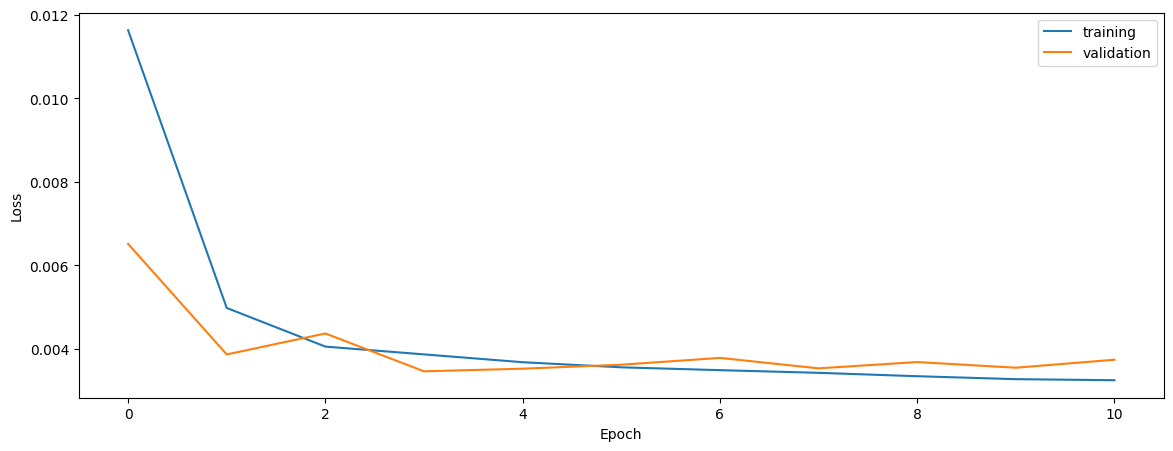

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7967262060546336
0.7966361527601511
0.7937588089385849


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7967262060546336
0.7966361527601511
0.7937588089385849


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7997275660876373
0.7961846229259241
0.7992534622168903


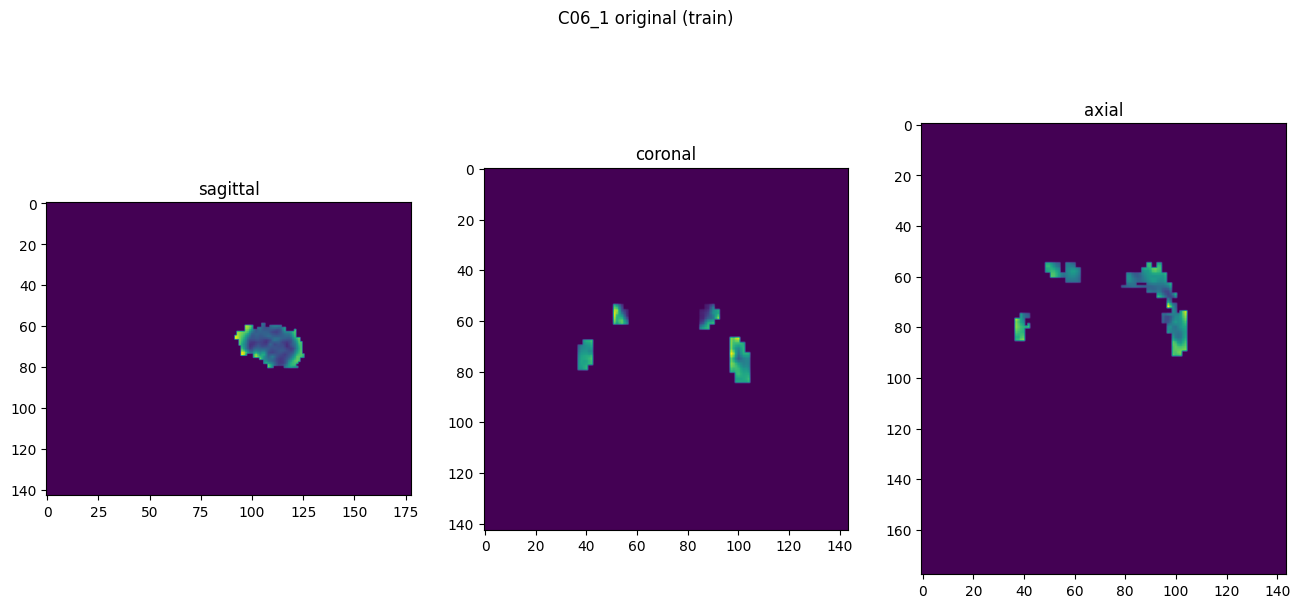

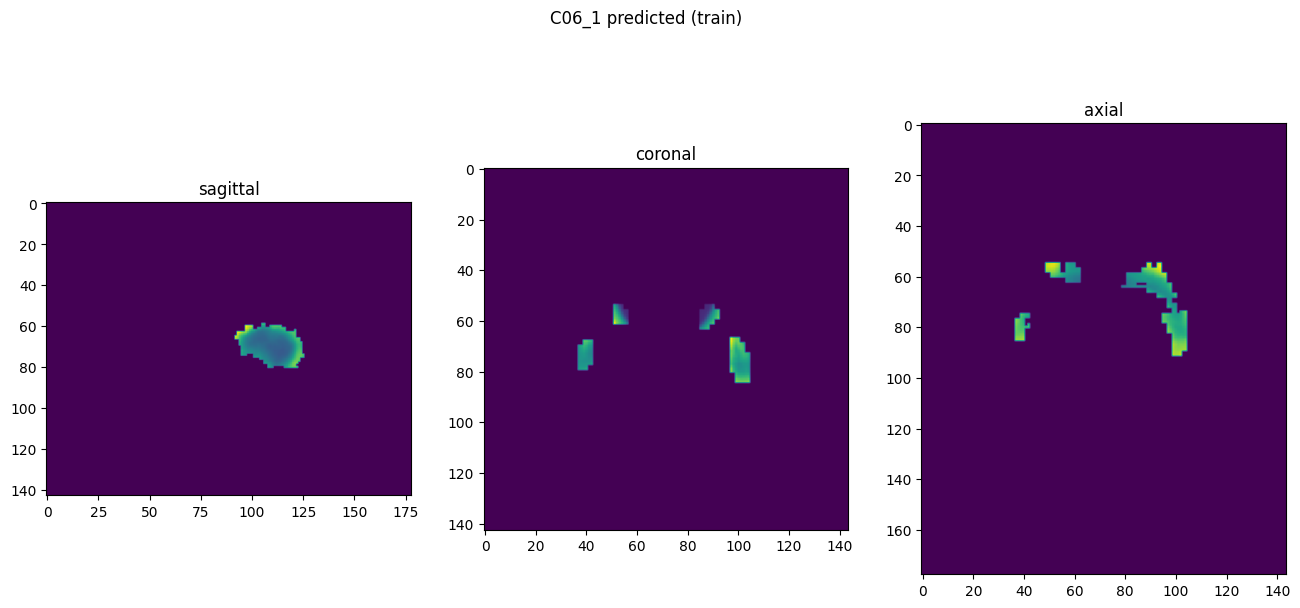

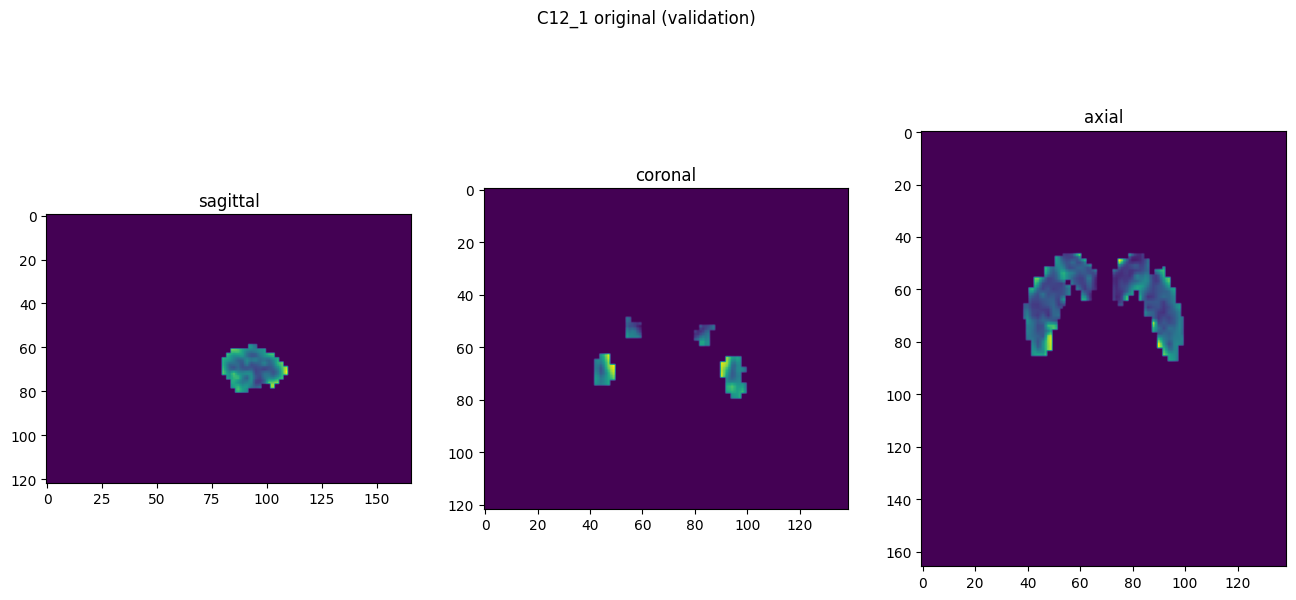

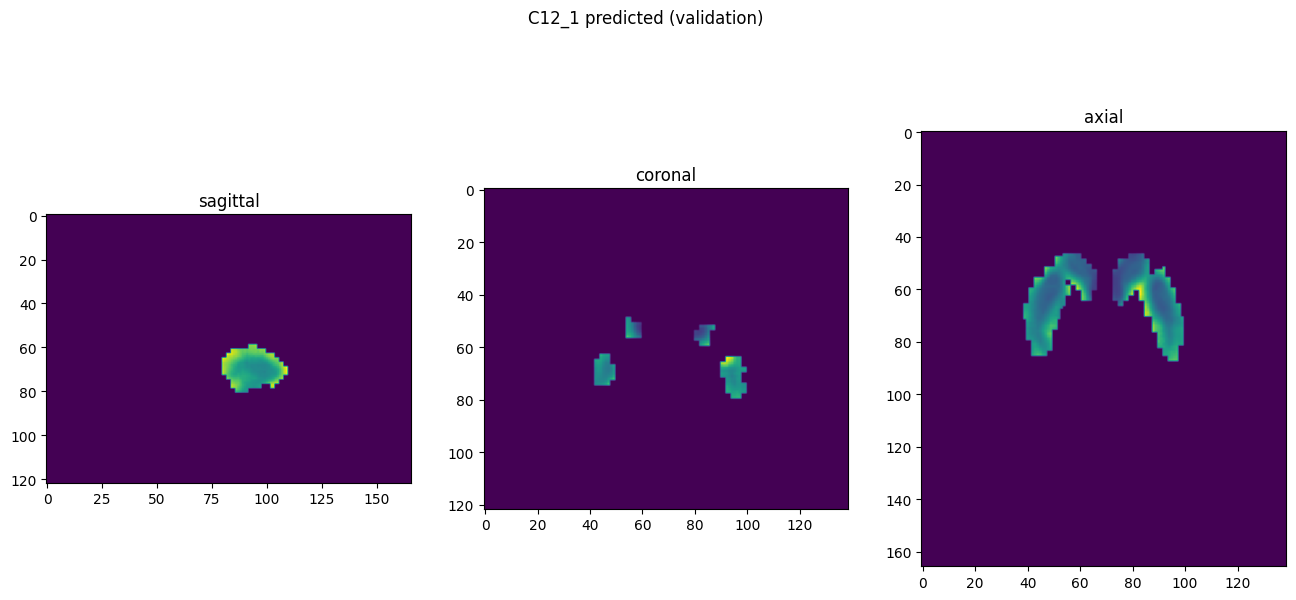

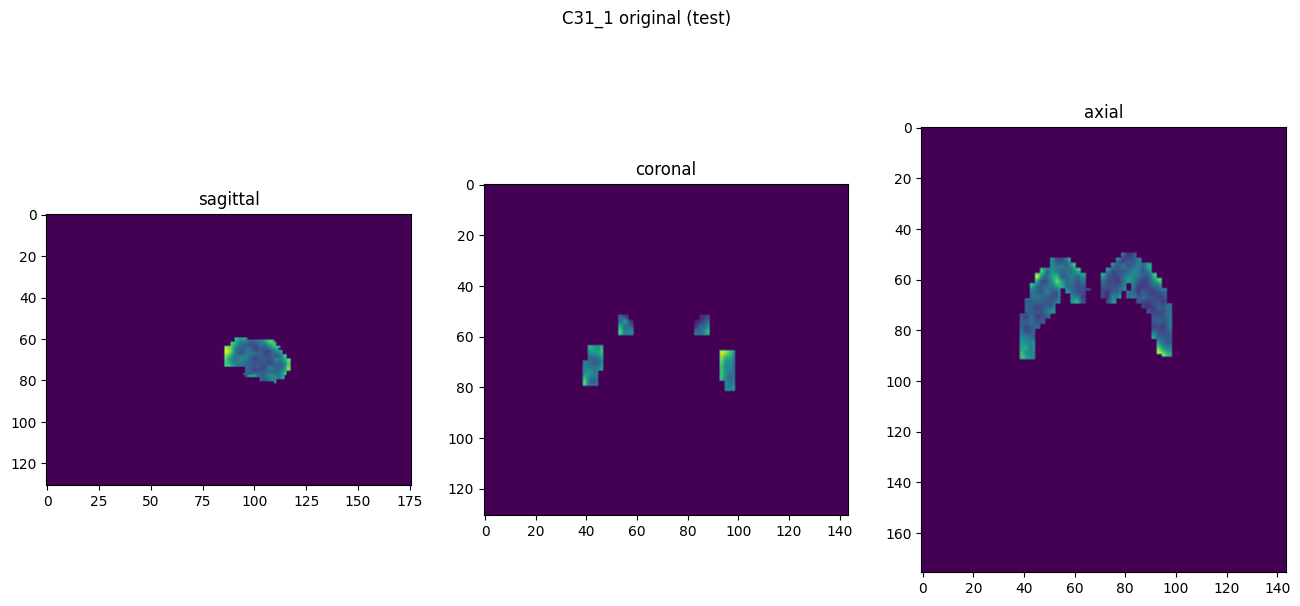

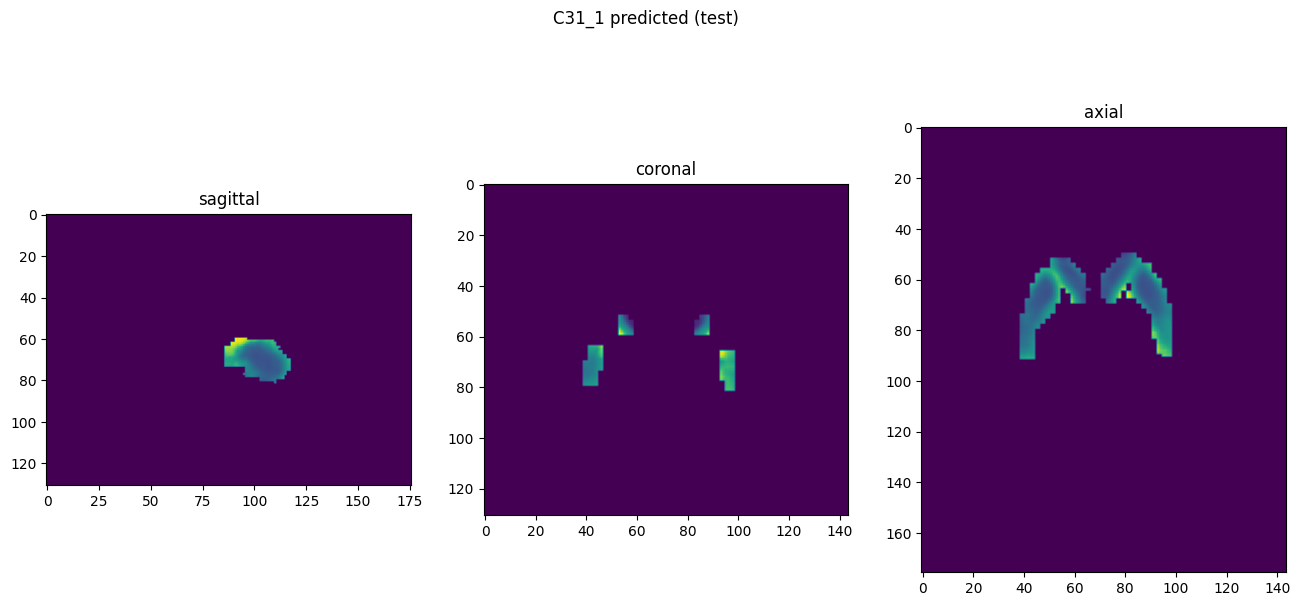

In [10]:
showResults(model, gen, threshold=None, background=False)